# Base Libraries --> Import

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
pip install lightgbm 

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install shap 

Note: you may need to restart the kernel to use updated packages.


In [2]:
#light bgm model
import lightgbm as lgb
import shap
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer

# Configuration
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Import Data 

In [3]:
# import data 

import pandas as pd

train = pd.read_csv('train.csv',parse_dates=['date'])
test = pd.read_csv('test.csv',parse_dates=['date'])
df= pd.concat([train, test], sort=False)


print(train.shape, test.shape, "\n")
train.head()



(913000, 4) (45000, 4) 



date  store  item  sales
0 2013-01-01      1     1     13
1 2013-01-02      1     1     11
2 2013-01-03      1     1     14
3 2013-01-04      1     1     13
4 2013-01-05      1     1     10

In [40]:
df

date  store  item  sales       id  month  day_of_year  year
0     2013-01-01      1     1   13.0      NaN      1            1  2013
1     2013-01-02      1     1   11.0      NaN      1            2  2013
2     2013-01-03      1     1   14.0      NaN      1            3  2013
3     2013-01-04      1     1   13.0      NaN      1            4  2013
4     2013-01-05      1     1   10.0      NaN      1            5  2013
...          ...    ...   ...    ...      ...    ...          ...   ...
44995 2018-03-27     10    50    NaN  44995.0      3           86  2018
44996 2018-03-28     10    50    NaN  44996.0      3           87  2018
44997 2018-03-29     10    50    NaN  44997.0      3           88  2018
44998 2018-03-30     10    50    NaN  44998.0      3           89  2018
44999 2018-03-31     10    50    NaN  44999.0      3           90  2018

[958000 rows x 8 columns]

In [5]:
print(df.head())

        date  store  item  sales  id
0 2013-01-01      1     1   13.0 NaN
1 2013-01-02      1     1   11.0 NaN
2 2013-01-03      1     1   14.0 NaN
3 2013-01-04      1     1   13.0 NaN
4 2013-01-05      1     1   10.0 NaN


# Data Analysis 

In [6]:
#Data Analysis
train.store.nunique() 

10

In [7]:
test.store.nunique(), train.item.nunique(), test.item.nunique()

(10, 50, 50)

In [8]:
## there are 10 store 
## there are 50 items 

In [5]:
# Time Range
train["date"].min(), train["date"].max(), test["date"].min(), test["date"].max()


(Timestamp('2013-01-01 00:00:00'),
 Timestamp('2017-12-31 00:00:00'),
 Timestamp('2018-01-01 00:00:00'),
 Timestamp('2018-03-31 00:00:00'))

In [6]:
# train == 2013-01-01 to 2017-12-31
# test == 2018-01-01 to 2018-03-31

In [11]:
# How many items are in the store?
df.groupby(["store"])["item"].nunique()

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

In [12]:
# Summary Stats for each store
df.groupby(["store"]).agg({"sales": ["count","sum", "mean", "median", "std", "min", "max"]})

sales                                                    
       count        sum       mean median        std  min    max
store                                                           
1      91300  4315603.0  47.268379   44.0  24.006252  1.0  155.0
2      91300  6120128.0  67.033165   62.0  33.595810  3.0  231.0
3      91300  5435144.0  59.530602   55.0  29.974102  3.0  196.0
4      91300  5012639.0  54.902946   51.0  27.733097  4.0  186.0
5      91300  3631016.0  39.770164   37.0  20.365757  2.0  130.0
6      91300  3627670.0  39.733516   37.0  20.310451  0.0  134.0
7      91300  3320009.0  36.363735   34.0  18.684825  1.0  122.0
8      91300  5856169.0  64.142048   60.0  32.231751  4.0  204.0
9      91300  5025976.0  55.049025   51.0  27.832186  4.0  195.0
10     91300  5360158.0  58.709288   54.0  29.554994  3.0  187.0

In [13]:
# Summary Stats for each item
df.groupby(["item"]).agg({"sales": ["count","sum", "mean", "median", "std", "min", "max"]})

sales                                                     
      count        sum       mean median        std   min    max
item                                                            
1     18260   401384.0  21.981599   21.0   8.468922   1.0   59.0
2     18260  1069564.0  58.574151   56.0  20.093015   9.0  150.0
3     18260   669087.0  36.642223   35.0  13.179441   7.0  104.0
4     18260   401907.0  22.010241   21.0   8.403898   0.0   66.0
5     18260   335230.0  18.358708   18.0   7.265167   1.0   50.0
6     18260  1068281.0  58.503888   56.0  20.174898  11.0  148.0
7     18260  1068777.0  58.531051   56.0  20.146002  11.0  141.0
8     18260  1405108.0  76.950055   74.0  26.130697  15.0  181.0
9     18260   938379.0  51.389869   49.5  17.790158   6.0  134.0
10    18260  1337133.0  73.227437   70.0  24.823725  14.0  175.0
11    18260  1271925.0  69.656353   67.0  23.744732  11.0  170.0
12    18260  1271534.0  69.634940   67.0  23.738663  12.0  170.0
13    18260  1539621.0  84.316594   81.0  28.311031  20.0  210.0
14    18260  1071531.0  58.681873   56.0  20.079860  12.0  152.0
15    18260  1607442.0  88.030778   85.0  29.522852  17.0  231.0
16    18260   468480.0  25.656079   25.0   9.603270   2.0   70.0
17    18260   602486.0  32.994852   32.0  11.967610   4.0   83.0
18    18260  1538876.0  84.275794   81.0  28.430621  18.0  208.0
19    18260   736892.0  40.355531   39.0  14.332645   5.0   99.0
20    18260   867641.0  47.515936   46.0  16.490487   9.0  127.0
21    18260   736190.0  40.317087   39.0  14.338006   7.0  109.0
22    18260  1469971.0  80.502245   78.0  27.118163  14.0  214.0
23    18260   534979.0  29.297864   28.0  10.819549   3.0   81.0
24    18260  1205975.0  66.044633   64.0  22.531555  14.0  156.0
25    18260  1473334.0  80.686418   78.0  27.238817  18.0  193.0
26    18260   869981.0  47.644085   46.0  16.723912   8.0  119.0
27    18260   402628.0  22.049726   21.0   8.461641   1.0   59.0
28    18260  1604713.0  87.881325   85.0  29.501781  16.0  206.0
29    18260  1271240.0  69.618839   67.0  23.635631  15.0  173.0
30    18260   736554.0  40.337021   39.0  14.363331   5.0  115.0
31    18260  1070845.0  58.644304   57.0  20.104705  10.0  159.0
32    18260   803107.0  43.981763   42.0  15.574556   5.0  119.0
33    18260  1270183.0  69.560953   67.0  23.718343  15.0  169.0
34    18260   469935.0  25.735761   25.0   9.617910   2.0   79.0
35    18260  1201541.0  65.801807   63.0  22.461990  12.0  168.0
36    18260  1406548.0  77.028916   74.0  26.067440  16.0  188.0
37    18260   534258.0  29.258379   28.0  10.771547   3.0   74.0
38    18260  1470330.0  80.521906   77.0  27.141799  15.0  188.0
39    18260   801311.0  43.883406   42.0  15.511550   7.0  112.0
40    18260   534094.0  29.249398   28.0  10.822959   3.0   74.0
41    18260   401759.0  22.002136   21.0   8.402470   2.0   60.0
42    18260   669925.0  36.688116   35.0  13.215112   5.0   96.0
43    18260   936635.0  51.294359   49.0  17.801008   9.0  126.0
44    18260   536811.0  29.398193   28.0  10.797738   3.0   78.0
45    18260  1471467.0  80.584173   78.0  27.318402  18.0  205.0
46    18260  1070764.0  58.639869   56.0  20.220879  11.0  150.0
47    18260   401781.0  22.003341   21.0   8.420102   2.0   61.0
48    18260   937703.0  51.352848   49.0  17.881917   8.0  130.0
49    18260   535663.0  29.335323   28.0  10.874788   3.0   77.0
50    18260  1203009.0  65.882202   63.0  22.416031  12.0  164.0

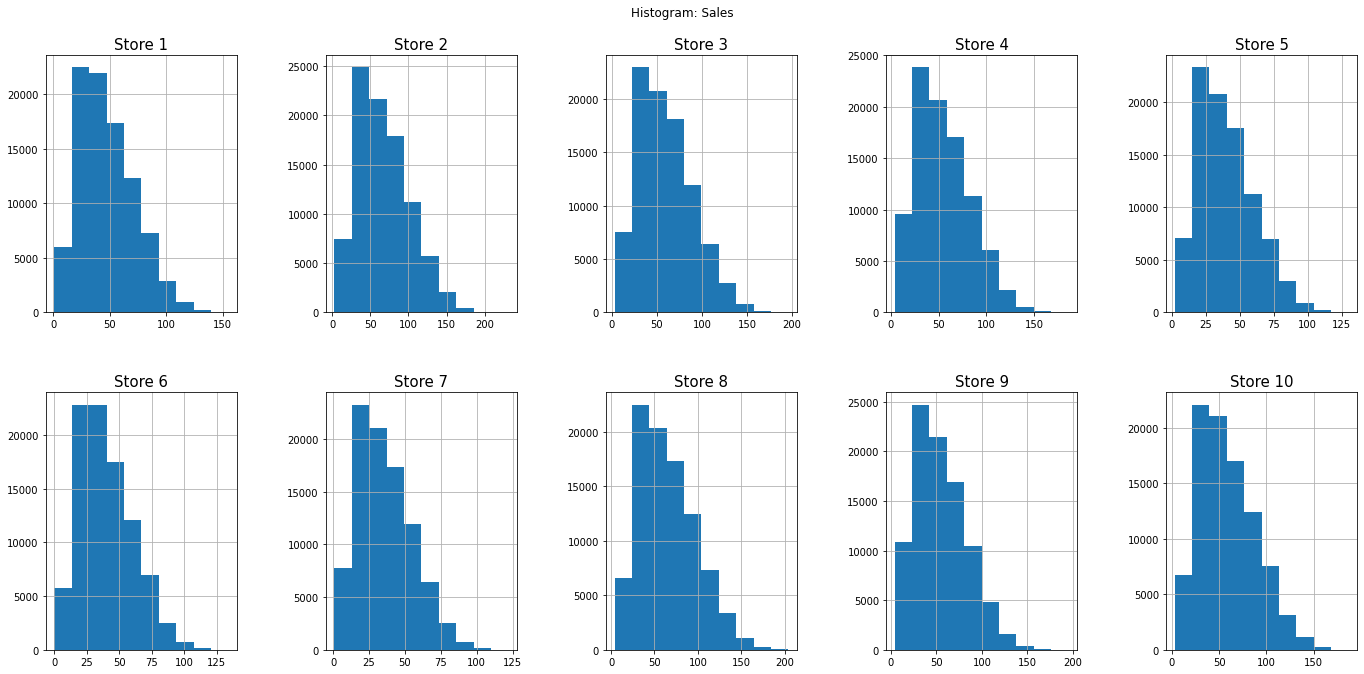

In [14]:
## Histogram : Store Sales

fig, axes = plt.subplots(2, 5,figsize=(20, 10)) ## in 2 rows and 5 columns 
for i in range(1,11):
    if i < 6:
        train[train.store == i].sales.hist(ax=axes[0, i-1])      ## graphical axes (0,0)==> center 
                                                                ## (0,1) ==> 1 co-ordinate right from center
        axes[0,i-1].set_title("Store " + str(i), fontsize = 15) ## subtitle  
        
    else:
        train[train.store == i].sales.hist(ax=axes[1, i - 6])
        axes[1,i-6].set_title("Store " + str(i), fontsize = 15)
        
## plotting histogram for each store sales 

plt.tight_layout(pad=4.5)  ## distance between each histogram of each store 
plt.suptitle("Histogram: Sales"); ## main title 


        


Enter store id8


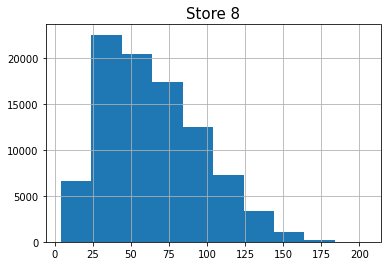

In [5]:
## optional 
store= input("Enter store id")
train[train.store == int(store)].sales.hist().set_title("Store " + str(store), fontsize = 15)

plt.show()


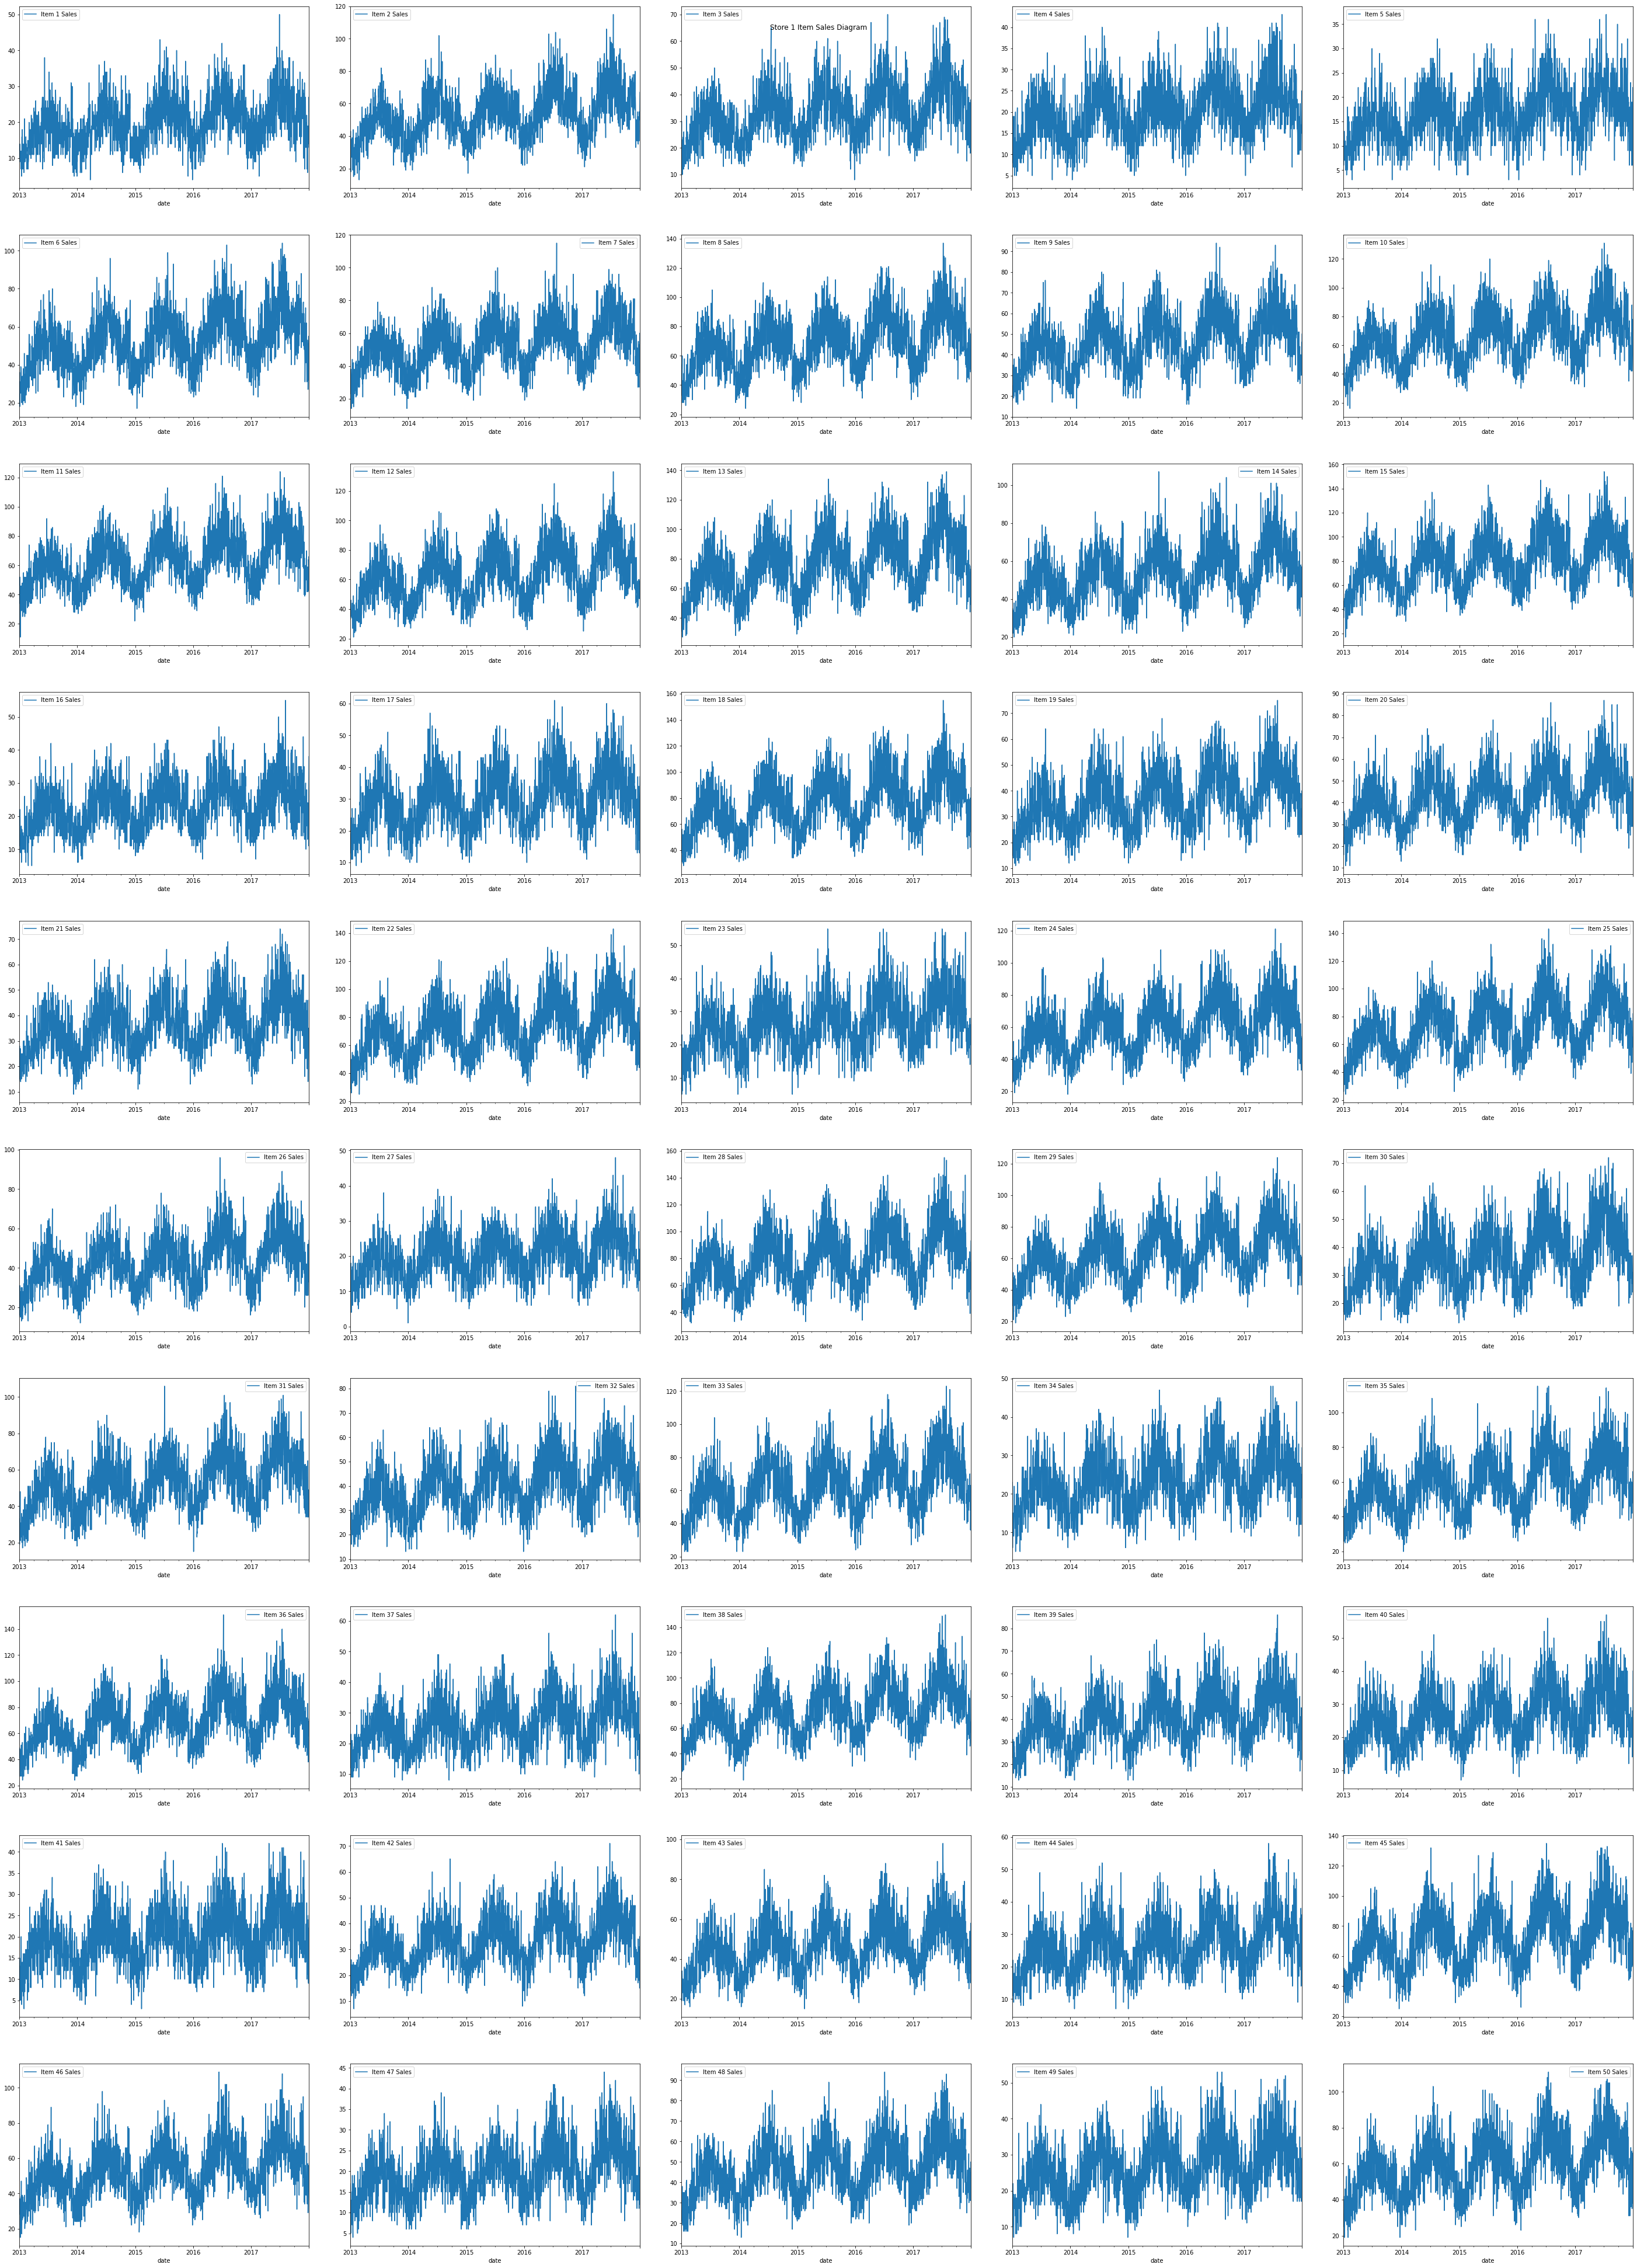

In [15]:
## histogram for item(50) sales in each store *here store 1*

store = 1
sub = train[train.store == store].set_index("date")

fig, axes = plt.subplots(10, 5, figsize=(40, 55)) #10 row, 5 column 
for i in range(1,51): ##since 50 item 
    if i < 6:
        sub[sub.item == i].sales.plot(ax=axes[0, i-1], legend=True, label = "Item "+str(i)+" Sales")
    if i >= 6 and i<11:
        sub[sub.item == i].sales.plot(ax=axes[1, i - 6], legend=True, label = "Item "+str(i)+" Sales")
    if i >= 11 and i<16:
        sub[sub.item == i].sales.plot(ax=axes[2, i - 11], legend=True, label = "Item "+str(i)+" Sales") 
    if i >= 16 and i<21:
        sub[sub.item == i].sales.plot(ax=axes[3, i - 16], legend=True, label = "Item "+str(i)+" Sales")    
    if i >= 21 and i<26:
        sub[sub.item == i].sales.plot(ax=axes[4, i - 21], legend=True, label = "Item "+str(i)+" Sales")  
    if i >= 26 and i<31:
        sub[sub.item == i].sales.plot(ax=axes[5, i - 26], legend=True, label = "Item "+str(i)+" Sales")    
    if i >= 31 and i<36:
        sub[sub.item == i].sales.plot(ax=axes[6, i - 31], legend=True, label = "Item "+str(i)+" Sales")    
    if i >= 36 and i<41:
        sub[sub.item == i].sales.plot(ax=axes[7, i - 36], legend=True, label = "Item "+str(i)+" Sales")    
    if i >= 41 and i<46:
        sub[sub.item == i].sales.plot(ax=axes[8, i - 41], legend=True, label = "Item "+str(i)+" Sales") 
    if i >= 46 and i<51:
        sub[sub.item == i].sales.plot(ax=axes[9, i - 46], legend=True, label = "Item "+str(i)+" Sales") 
plt.tight_layout(pad=4.5)
plt.suptitle("Store 1 Item Sales Diagram");
plt.show()

Enter the store id8
Enter the item number9


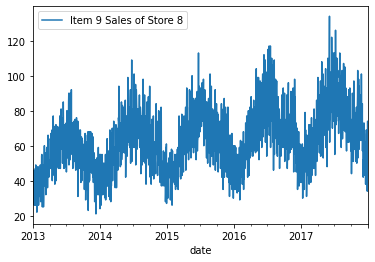

In [6]:
##optional 

store= input("Enter the store id")
item = input("Enter the item number")
#store = 2
#item = 30
sub = train[train.store == int(store)].set_index("date")
sub[sub.item == int(item)].sales.plot(legend=True, label = "Item "+str(item)+" Sales"+" of Store "+str(store)) 


plt.show()

# Feature Engineering

In [199]:

# Time-related feature == creating time related features

def create_date_features(df):
    df['month'] = df.date.dt.month
    df['day_of_month'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['week_of_year'] = df.date.dt.weekofyear
    df['day_of_week'] = df.date.dt.dayofweek + 1
    df['year'] = df.date.dt.year
    df["is_wknd"] = df.date.dt.weekday // 4   ### df.date.dt.weekday => Starts from '0' means '0' = 'Monday'. 
                                               ##So, '// 4' will give '1' when day number equals
                                            ## so does for 5 and 6 gives '1' for //4
    df['is_month_start'] = df.date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.date.dt.is_month_end.astype(int)
    df['is_year_start'] = df.date.dt.is_year_start.astype(int)
    df['is_year_end'] = df.date.dt.is_year_end.astype(int)
    return df
df = create_date_features(df)

In [4]:

# Time-related feature == creating time related features

def create_date_features(df):
    df['month'] = df.date.dt.month
    df['day_of_year'] = df.date.dt.dayofyear
    df['year'] = df.date.dt.year
    return df
df = create_date_features(df)

In [6]:
df

date  store  item  sales       id  month  day_of_year  year
0     2013-01-01      1     1   13.0      NaN      1            1  2013
1     2013-01-02      1     1   11.0      NaN      1            2  2013
2     2013-01-03      1     1   14.0      NaN      1            3  2013
3     2013-01-04      1     1   13.0      NaN      1            4  2013
4     2013-01-05      1     1   10.0      NaN      1            5  2013
...          ...    ...   ...    ...      ...    ...          ...   ...
44995 2018-03-27     10    50    NaN  44995.0      3           86  2018
44996 2018-03-28     10    50    NaN  44996.0      3           87  2018
44997 2018-03-29     10    50    NaN  44997.0      3           88  2018
44998 2018-03-30     10    50    NaN  44998.0      3           89  2018
44999 2018-03-31     10    50    NaN  44999.0      3           90  2018

[958000 rows x 8 columns]

In [201]:

#Lag/Shifted Features
#==> 1. every feature should be sorted 
#==> 2. generate new features for each 'item' in each 'store' according to 'date' order

#to sort 
df.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)

#lagging ==> how many sales 1 day before in column "lag1" and so on
"""but here new features are being generated using target variable= sales 
and since target variable is being used == data leakage is possible / overfitteing of data ==> machine loses generalization ability
so adding random noise"""



#lagging 
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe) # Adding random noise to each value.
    return dataframe

#random noise
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

# passing variables and creating feature
lags_list = [91, 98, 105, 112, 119, 126, 182, 364, 546, 728] 
df = lag_features(df, lags_list) 




In [9]:
df.tail()

date  store  item  sales  month  day_of_month  day_of_year  \
912995 2017-12-27     10    50     63     12            27          361   
912996 2017-12-28     10    50     59     12            28          362   
912997 2017-12-29     10    50     74     12            29          363   
912998 2017-12-30     10    50     62     12            30          364   
912999 2017-12-31     10    50     82     12            31          365   

        week_of_year  day_of_week  year  is_wknd  is_month_start  \
912995            52            3  2017        0               0   
912996            52            4  2017        0               0   
912997            52            5  2017        1               0   
912998            52            6  2017        1               0   
912999            52            7  2017        1               0   

        is_month_end  is_year_start  is_year_end  sales_lag_91  sales_lag_98  \
912995             0              0            0     79.459121     69.240378   
912996             0              0            0     80.031193     90.457982   
912997             0              0            0     90.740414     93.926562   
912998             0              0            0    103.035246     96.475973   
912999             1              0            1    101.194336     98.253530   

        sales_lag_105  sales_lag_112  sales_lag_119  sales_lag_126  \
912995      83.952418      78.106718      78.135913     105.380828   
912996      89.660907      79.000433      85.819931      85.647331   
912997      92.623187      98.547457      94.104022      98.405634   
912998      95.235967      92.601097      92.491923      93.980973   
912999     106.338737      94.136752     100.953156     117.495927   

        sales_lag_182  sales_lag_364  sales_lag_546  sales_lag_728  
912995      91.910752      39.045023      76.245201      48.233918  
912996     120.185679      66.858756      89.187127      45.373524  
912997     113.001192      60.050811      98.985582      59.018588  
912998     118.363723      62.061015     111.740224      62.119957  
912999     118.569559      70.906164     124.999940      79.681739

In [202]:

## Rolling mean feature ==> takes "n" previous target variable and averages them and returns as a new value

"""For instance "roll2" takes previous 2 variable and averages it 
Again it uses target variables 
so adding noise on purpose """

def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(dataframe)
    return dataframe

roll_mean_list = [365, 546]
df = roll_mean_features(df, roll_mean_list)

In [11]:
df.tail()

date  store  item  sales  month  day_of_month  day_of_year  \
912995 2017-12-27     10    50     63     12            27          361   
912996 2017-12-28     10    50     59     12            28          362   
912997 2017-12-29     10    50     74     12            29          363   
912998 2017-12-30     10    50     62     12            30          364   
912999 2017-12-31     10    50     82     12            31          365   

        week_of_year  day_of_week  year  is_wknd  is_month_start  \
912995            52            3  2017        0               0   
912996            52            4  2017        0               0   
912997            52            5  2017        1               0   
912998            52            6  2017        1               0   
912999            52            7  2017        1               0   

        is_month_end  is_year_start  is_year_end  sales_lag_91  sales_lag_98  \
912995             0              0            0     79.459121     69.240378   
912996             0              0            0     80.031193     90.457982   
912997             0              0            0     90.740414     93.926562   
912998             0              0            0    103.035246     96.475973   
912999             1              0            1    101.194336     98.253530   

        sales_lag_105  sales_lag_112  sales_lag_119  sales_lag_126  \
912995      83.952418      78.106718      78.135913     105.380828   
912996      89.660907      79.000433      85.819931      85.647331   
912997      92.623187      98.547457      94.104022      98.405634   
912998      95.235967      92.601097      92.491923      93.980973   
912999     106.338737      94.136752     100.953156     117.495927   

        sales_lag_182  sales_lag_364  sales_lag_546  sales_lag_728  \
912995      91.910752      39.045023      76.245201      48.233918   
912996     120.185679      66.858756      89.187127      45.373524   
912997     113.001192      60.050811      98.985582      59.018588   
912998     118.363723      62.061015     111.740224      62.119957   
912999     118.569559      70.906164     124.999940      79.681739   

        sales_roll_mean_365  sales_roll_mean_546  
912995            89.950690            81.049480  
912996            87.384114            83.035634  
912997            89.641516            81.056099  
912998            90.317038            80.137694  
912999            90.364264            84.744543

In [203]:

#Exponentially Weighted Mean Features ==> parameter alpha [0,1]
                                         #alpha close to 1 == more weight to close days 
    
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

# In here we have two combinations : alphas and lags. 
alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

df = ewm_features(df, alphas, lags)



In [208]:
df

date  store  item  sales       id  month  day_of_month  \
0     2013-01-01      1     1   13.0      NaN      1             1   
1     2013-01-02      1     1   11.0      NaN      1             2   
2     2013-01-03      1     1   14.0      NaN      1             3   
3     2013-01-04      1     1   13.0      NaN      1             4   
4     2013-01-05      1     1   10.0      NaN      1             5   
...          ...    ...   ...    ...      ...    ...           ...   
44995 2018-03-27     10    50    NaN  44995.0      3            27   
44996 2018-03-28     10    50    NaN  44996.0      3            28   
44997 2018-03-29     10    50    NaN  44997.0      3            29   
44998 2018-03-30     10    50    NaN  44998.0      3            30   
44999 2018-03-31     10    50    NaN  44999.0      3            31   

       day_of_year  week_of_year  day_of_week  year  is_wknd  is_month_start  \
0                1             1            2  2013        0               1   
1                2             1            3  2013        0               0   
2                3             1            4  2013        0               0   
3                4             1            5  2013        1               0   
4                5             1            6  2013        1               0   
...            ...           ...          ...   ...      ...             ...   
44995           86            13            2  2018        0               0   
44996           87            13            3  2018        0               0   
44997           88            13            4  2018        0               0   
44998           89            13            5  2018        1               0   
44999           90            13            6  2018        1               0   

       is_month_end  is_year_start  is_year_end  sales_lag_91  sales_lag_98  \
0                 0              1            0           NaN           NaN   
1                 0              0            0           NaN           NaN   
2                 0              0            0           NaN           NaN   
3                 0              0            0           NaN           NaN   
4                 0              0            0           NaN           NaN   
...             ...            ...          ...           ...           ...   
44995             0              0            0     40.394828     51.989095   
44996             0              0            0     63.906591     50.135353   
44997             0              0            0     59.598973     65.506978   
44998             0              0            0     75.950892     77.427698   
44999             1              0            0     57.593429     69.263637   

       sales_lag_105  sales_lag_112  sales_lag_119  sales_lag_126  \
0                NaN            NaN            NaN            NaN   
1                NaN            NaN            NaN            NaN   
2                NaN            NaN            NaN            NaN   
3                NaN            NaN            NaN            NaN   
4                NaN            NaN            NaN            NaN   
...              ...            ...            ...            ...   
44995      67.310537      71.331111      70.314646      79.692493   
44996      67.869859      61.202072      77.505099      79.212725   
44997      71.945544      67.175768      74.087803      89.084102   
44998      71.326315      67.482926      64.298063      81.191145   
44999      52.670079      65.979949      47.932084      78.191627   

       sales_lag_182  sales_lag_364  sales_lag_546  sales_lag_728  \
0                NaN            NaN            NaN            NaN   
1                NaN            NaN            NaN            NaN   
2                NaN            NaN            NaN            NaN   
3                NaN            NaN            NaN            NaN   
4                NaN            NaN            NaN            NaN   
...              .

In [7]:
##Done few feature engineering now shape of data:
df.shape

(958000, 8)

In [12]:
#one-hot encoding ==> ensures that machine learning does not assume that higher numbers are more important

#df = pd.get_dummies(df, columns=['store', 'item'])
#df.head()

date  sales  month  day_of_month  day_of_year  week_of_year  \
0 2013-01-01     13      1             1            1             1   
1 2013-01-02     11      1             2            2             1   
2 2013-01-03     14      1             3            3             1   
3 2013-01-04     13      1             4            4             1   
4 2013-01-05     10      1             5            5             1   

   day_of_week  year  is_wknd  is_month_start  is_month_end  is_year_start  \
0            2  2013        0               1             0              1   
1            3  2013        0               0             0              0   
2            4  2013        0               0             0              0   
3            5  2013        1               0             0              0   
4            6  2013        1               0             0              0   

   is_year_end  sales_lag_91  sales_lag_98  sales_lag_105  sales_lag_112  \
0            0           NaN           NaN            NaN            NaN   
1            0           NaN           NaN            NaN            NaN   
2            0           NaN           NaN            NaN            NaN   
3            0           NaN           NaN            NaN            NaN   
4            0           NaN           NaN            NaN            NaN   

   sales_lag_119  sales_lag_126  sales_lag_182  sales_lag_364  sales_lag_546  \
0            NaN            NaN            NaN            NaN            NaN   
1            NaN            NaN            NaN            NaN            NaN   
2            NaN            NaN            NaN            NaN            NaN   
3            NaN            NaN            NaN            NaN            NaN   
4            NaN            NaN            NaN            NaN            NaN   

   sales_lag_728  sales_roll_mean_365  sales_roll_mean_546  \
0            NaN                  NaN                  NaN   
1            NaN                  NaN                  NaN   
2            NaN                  NaN                  NaN   
3            NaN                  NaN                  NaN   
4            NaN                  NaN                  NaN   

   sales_ewm_alpha_095_lag_91  sales_ewm_alpha_095_lag_98  \
0                         NaN                         NaN   
1                         NaN                         NaN   
2                         NaN                         NaN   
3                         NaN                         NaN   
4                         NaN                         NaN   

   sales_ewm_alpha_095_lag_105  sales_ewm_alpha_095_lag_112  \
0                          NaN                          NaN   
1                          NaN                          NaN   
2                          NaN                          NaN   
3                          NaN                          NaN   
4                          NaN                          NaN   

   sales_ewm_alpha_095_lag_180  sales_ewm_alpha_095_lag_270  \
0                          NaN                          NaN   
1                          NaN                          NaN   
2                          NaN                          NaN   
3                          NaN                          NaN   
4                          NaN                          NaN   

   sales_ewm_alpha_095_lag_365  sales_ewm_alpha_095_lag_546  \
0                          NaN                          NaN   
1                          NaN                          NaN   
2                          NaN                          NaN   
3                          NaN                          NaN   
4                          NaN                          NaN   

   sales_ewm_alpha_095_lag_728  sales_ewm_alpha_09_lag_91  \
0                          NaN                        NaN   
1                          NaN                        NaN   
2                          NaN                        NaN   
3                          NaN                       

In [43]:
#fill NAN values with mean
df['sales_lag_91'].fillna(int(df['sales_lag_91'].mean()), inplace=True)
df['sales_lag_98'].fillna(int(df['sales_lag_98'].mean()), inplace=True)
df['sales_lag_105'].fillna(int(df['sales_lag_105'].mean()), inplace=True)
df['sales_lag_112'].fillna(int(df['sales_lag_112'].mean()), inplace=True)
df['sales_lag_119'].fillna(int(df['sales_lag_119'].mean()), inplace=True)
df['sales_lag_126'].fillna(int(df['sales_lag_126'].mean()), inplace=True)
df['sales_lag_182'].fillna(int(df['sales_lag_182'].mean()), inplace=True)
df['sales_lag_364'].fillna(int(df['sales_lag_364'].mean()), inplace=True)
df['sales_lag_546'].fillna(int(df['sales_lag_546'].mean()), inplace=True)
df['sales_lag_728'].fillna(int(df['sales_lag_728'].mean()), inplace=True)

In [44]:
df['sales_roll_mean_365'].fillna(int(df['sales_roll_mean_365'].mean()),inplace=True)
df['sales_roll_mean_546'].fillna(int(df['sales_roll_mean_546'].mean()),inplace=True)

In [45]:
df['sales_ewm_alpha_095_lag_91'].fillna(int(df['sales_ewm_alpha_095_lag_91'].mean()),inplace=True)
df['sales_ewm_alpha_095_lag_98'].fillna(int(df['sales_ewm_alpha_095_lag_98'].mean()),inplace=True)
df['sales_ewm_alpha_095_lag_105'].fillna(int(df['sales_ewm_alpha_095_lag_105'].mean()),inplace=True)
df['sales_ewm_alpha_095_lag_112'].fillna(int(df['sales_ewm_alpha_095_lag_112'].mean()),inplace=True)
df['sales_ewm_alpha_095_lag_180'].fillna(int(df['sales_ewm_alpha_095_lag_180'].mean()),inplace=True)
df['sales_ewm_alpha_095_lag_270'].fillna(int(df['sales_ewm_alpha_095_lag_270'].mean()),inplace=True)
df['sales_ewm_alpha_095_lag_365'].fillna(int(df['sales_ewm_alpha_095_lag_365'].mean()),inplace=True)
df['sales_ewm_alpha_095_lag_546'].fillna(int(df['sales_ewm_alpha_095_lag_546'].mean()),inplace=True)
df['sales_ewm_alpha_095_lag_728'].fillna(int(df['sales_ewm_alpha_095_lag_728'].mean()),inplace=True)

In [46]:
df['sales_ewm_alpha_09_lag_91'].fillna(int(df['sales_ewm_alpha_09_lag_91'].mean()),inplace=True)
df['sales_ewm_alpha_09_lag_98'].fillna(int(df['sales_ewm_alpha_09_lag_98'].mean()),inplace=True)
df['sales_ewm_alpha_09_lag_105'].fillna(int(df['sales_ewm_alpha_09_lag_105'].mean()),inplace=True)
df['sales_ewm_alpha_09_lag_112'].fillna(int(df['sales_ewm_alpha_09_lag_112'].mean()),inplace=True)
df['sales_ewm_alpha_09_lag_180'].fillna(int(df['sales_ewm_alpha_09_lag_180'].mean()),inplace=True)
df['sales_ewm_alpha_09_lag_270'].fillna(int(df['sales_ewm_alpha_09_lag_270'].mean()),inplace=True)
df['sales_ewm_alpha_09_lag_365'].fillna(int(df['sales_ewm_alpha_09_lag_365'].mean()),inplace=True)
df['sales_ewm_alpha_09_lag_546'].fillna(int(df['sales_ewm_alpha_09_lag_546'].mean()),inplace=True)
df['sales_ewm_alpha_09_lag_728'].fillna(int(df['sales_ewm_alpha_09_lag_728'].mean()),inplace=True)

In [47]:
df['sales_ewm_alpha_08_lag_91'].fillna(int(df['sales_ewm_alpha_08_lag_91'].mean()),inplace=True)
df['sales_ewm_alpha_08_lag_98'].fillna(int(df['sales_ewm_alpha_08_lag_98'].mean()),inplace=True)
df['sales_ewm_alpha_08_lag_105'].fillna(int(df['sales_ewm_alpha_08_lag_105'].mean()),inplace=True)
df['sales_ewm_alpha_08_lag_112'].fillna(int(df['sales_ewm_alpha_08_lag_112'].mean()),inplace=True)
df['sales_ewm_alpha_08_lag_180'].fillna(int(df['sales_ewm_alpha_08_lag_180'].mean()),inplace=True)
df['sales_ewm_alpha_08_lag_270'].fillna(int(df['sales_ewm_alpha_08_lag_270'].mean()),inplace=True)
df['sales_ewm_alpha_08_lag_365'].fillna(int(df['sales_ewm_alpha_08_lag_365'].mean()),inplace=True)
df['sales_ewm_alpha_08_lag_546'].fillna(int(df['sales_ewm_alpha_08_lag_546'].mean()),inplace=True)
df['sales_ewm_alpha_08_lag_728'].fillna(int(df['sales_ewm_alpha_08_lag_728'].mean()),inplace=True)

In [48]:
df['sales_ewm_alpha_07_lag_91'].fillna(int(df['sales_ewm_alpha_07_lag_91'].mean()),inplace=True)
df['sales_ewm_alpha_07_lag_98'].fillna(int(df['sales_ewm_alpha_07_lag_98'].mean()),inplace=True)
df['sales_ewm_alpha_07_lag_105'].fillna(int(df['sales_ewm_alpha_07_lag_105'].mean()),inplace=True)
df['sales_ewm_alpha_07_lag_112'].fillna(int(df['sales_ewm_alpha_07_lag_112'].mean()),inplace=True)
df['sales_ewm_alpha_07_lag_180'].fillna(int(df['sales_ewm_alpha_07_lag_180'].mean()),inplace=True)
df['sales_ewm_alpha_07_lag_270'].fillna(int(df['sales_ewm_alpha_07_lag_270'].mean()),inplace=True)
df['sales_ewm_alpha_07_lag_365'].fillna(int(df['sales_ewm_alpha_07_lag_365'].mean()),inplace=True)
df['sales_ewm_alpha_07_lag_546'].fillna(int(df['sales_ewm_alpha_07_lag_546'].mean()),inplace=True)
df['sales_ewm_alpha_07_lag_728'].fillna(int(df['sales_ewm_alpha_07_lag_728'].mean()),inplace=True)

In [49]:
df['sales_ewm_alpha_05_lag_91'].fillna(int(df['sales_ewm_alpha_05_lag_91'].mean()),inplace=True)
df['sales_ewm_alpha_05_lag_98'].fillna(int(df['sales_ewm_alpha_05_lag_98'].mean()),inplace=True)
df['sales_ewm_alpha_05_lag_105'].fillna(int(df['sales_ewm_alpha_05_lag_105'].mean()),inplace=True)
df['sales_ewm_alpha_05_lag_112'].fillna(int(df['sales_ewm_alpha_05_lag_112'].mean()),inplace=True)
df['sales_ewm_alpha_05_lag_180'].fillna(int(df['sales_ewm_alpha_05_lag_180'].mean()),inplace=True)
df['sales_ewm_alpha_05_lag_270'].fillna(int(df['sales_ewm_alpha_05_lag_270'].mean()),inplace=True)
df['sales_ewm_alpha_05_lag_365'].fillna(int(df['sales_ewm_alpha_05_lag_365'].mean()),inplace=True)
df['sales_ewm_alpha_05_lag_546'].fillna(int(df['sales_ewm_alpha_05_lag_546'].mean()),inplace=True)
df['sales_ewm_alpha_05_lag_728'].fillna(int(df['sales_ewm_alpha_05_lag_728'].mean()),inplace=True)

In [4]:
#standardization
#train['sales'] = np.log1p(train["sales"].values)

In [50]:
df.head()

date  store  item  sales  month  day_of_month  day_of_year  \
0 2013-01-01      1     1     13      1             1            1   
1 2013-01-02      1     1     11      1             2            2   
2 2013-01-03      1     1     14      1             3            3   
3 2013-01-04      1     1     13      1             4            4   
4 2013-01-05      1     1     10      1             5            5   

   week_of_year  day_of_week  year  is_wknd  is_month_start  is_month_end  \
0             1            2  2013        0               1             0   
1             1            3  2013        0               0             0   
2             1            4  2013        0               0             0   
3             1            5  2013        1               0             0   
4             1            6  2013        1               0             0   

   is_year_start  is_year_end  sales_lag_91  sales_lag_98  sales_lag_105  \
0              1            0          52.0          52.0           52.0   
1              0            0          52.0          52.0           52.0   
2              0            0          52.0          52.0           52.0   
3              0            0          52.0          52.0           52.0   
4              0            0          52.0          52.0           52.0   

   sales_lag_112  sales_lag_119  sales_lag_126  sales_lag_182  sales_lag_364  \
0           52.0           51.0           51.0           51.0           50.0   
1           52.0           51.0           51.0           51.0           50.0   
2           52.0           51.0           51.0           51.0           50.0   
3           52.0           51.0           51.0           51.0           50.0   
4           52.0           51.0           51.0           51.0           50.0   

   sales_lag_546  sales_lag_728  sales_roll_mean_365  sales_roll_mean_546  \
0           49.0           48.0                 49.0                 48.0   
1           49.0           48.0                 49.0                 48.0   
2           49.0           48.0                 49.0                 48.0   
3           49.0           48.0                 49.0                 48.0   
4           49.0           48.0                 49.0                 48.0   

   sales_ewm_alpha_095_lag_91  sales_ewm_alpha_095_lag_98  \
0                        52.0                        52.0   
1                        52.0                        52.0   
2                        52.0                        52.0   
3                        52.0                        52.0   
4                        52.0                        52.0   

   sales_ewm_alpha_095_lag_105  sales_ewm_alpha_095_lag_112  \
0                         52.0                         52.0   
1                         52.0                         52.0   
2                         52.0                         52.0   
3                         52.0                         52.0   
4                         52.0                         52.0   

   sales_ewm_alpha_095_lag_180  sales_ewm_alpha_095_lag_270  \
0                         51.0                         50.0   
1                         51.0                         50.0   
2                         51.0                         50.0   
3                         51.0                         50.0   
4                         51.0                         50.0   

   sales_ewm_alpha_095_lag_365  sales_ewm_alpha_095_lag_546  \
0                         50.0                         49.0   
1                         50.0                         49.0   
2                         50.0                         49.0   
3                         50.0                         49.0   
4                         50.0                         49.0   

   sales_ewm_alpha_095_lag_728  sales_ewm_alpha_09_lag_91  \
0                         48.0                       52.0   
1                         48.0                       52.0   
2                         48.0      

In [8]:
##SMAPE score

def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val

# Calculating SMAPE for LightGBM output:
def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

# Split data

In [9]:
#  train and validation set.
train = df.loc[(df["date"] < "2017-01-01"), :] # Until beginning of 2017
val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2018-01-01"), :] # Year of 2017

#dropping useless column
cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

Y_train = train['sales']
X_train = train[cols]

Y_val = val['sales']
X_val = val[cols]

Y_train.shape, X_train.shape, Y_val.shape, X_val.shape


((730500,), (730500, 4), (182500,), (182500, 4))

# Lgbm model

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score ,mean_absolute_percentage_error

In [89]:
#lgbm in without any parameters 
first_model = lgb.LGBMRegressor().fit(X_train, Y_train)

print("TRAIN SMAPE:", smape(Y_train, first_model.predict(X_train)))
print("VALID SMAPE:", smape(Y_val, first_model.predict(X_val)))
pred = first_model.predict(X_train)
print("MAE:",mean_absolute_error(Y_train, pred))
print("RMSE:",mean_squared_error(Y_train, pred))
print("R2 Score:",r2_score(Y_train, pred))
print("MAPE:",mean_absolute_percentage_error(Y_train, pred))

TRAIN SMAPE: 13.419954514176505
VALID SMAPE: 12.454179763700617
MAE: 5.765554665129783
RMSE: 56.07346374149178
R2 Score: 0.9276061808052498
MAPE: 70543317950.45807


# Catboost Regressor

In [43]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [43]:


from catboost import CatBoostRegressor
second_model = CatBoostRegressor()
second_model.fit(X_train, Y_train)

print("TRAIN SMAPE:", smape(Y_train, second_model.predict(X_train)))
print("VALID SMAPE:", smape(Y_val, second_model.predict(X_val)))
pred = second_model.predict(X_train)
print("MAE:",mean_absolute_error(Y_train, pred))
print("RMSE:",mean_squared_error(Y_train, pred))
print("R2 Score:",r2_score(Y_train, pred))
print("MAPE:",mean_absolute_percentage_error(Y_train, pred))


Learning rate set to 0.116046
0:	learn: 26.8637435	total: 93.3ms	remaining: 1m 33s
1:	learn: 26.1940479	total: 188ms	remaining: 1m 33s
2:	learn: 25.4855270	total: 307ms	remaining: 1m 42s
3:	learn: 24.9601450	total: 408ms	remaining: 1m 41s
4:	learn: 24.5252617	total: 515ms	remaining: 1m 42s
5:	learn: 24.1128712	total: 601ms	remaining: 1m 39s
6:	learn: 23.7074759	total: 722ms	remaining: 1m 42s
7:	learn: 23.3682498	total: 816ms	remaining: 1m 41s
8:	learn: 23.0206398	total: 896ms	remaining: 1m 38s
9:	learn: 22.6900169	total: 1.12s	remaining: 1m 50s
10:	learn: 22.4000549	total: 1.22s	remaining: 1m 49s
11:	learn: 22.1406821	total: 1.31s	remaining: 1m 48s
12:	learn: 21.8923551	total: 1.45s	remaining: 1m 50s
13:	learn: 21.6653453	total: 1.55s	remaining: 1m 49s
14:	learn: 21.4546234	total: 1.65s	remaining: 1m 48s
15:	learn: 21.2536347	total: 1.78s	remaining: 1m 49s
16:	learn: 21.0246286	total: 1.88s	remaining: 1m 48s
17:	learn: 20.8219033	total: 1.96s	remaining: 1m 46s
18:	learn: 20.6791168	tot

In [47]:
X_val

store  item  month  day_of_year  year
1461        1     1      1            1  2017
1462        1     1      1            2  2017
1463        1     1      1            3  2017
1464        1     1      1            4  2017
1465        1     1      1            5  2017
...       ...   ...    ...          ...   ...
912995     10    50     12          361  2017
912996     10    50     12          362  2017
912997     10    50     12          363  2017
912998     10    50     12          364  2017
912999     10    50     12          365  2017

[182500 rows x 5 columns]

# XGBoost

In [123]:
from xgboost.sklearn import XGBRegressor
third_model = XGBRegressor()
third_model.fit(X_train, Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [124]:
print("TRAIN SMAPE:", smape(Y_train, third_model.predict(X_train)))
print("VALID SMAPE:", smape(Y_val, third_model.predict(X_val)))
pred = third_model.predict(X_train)
print("MAE:",mean_absolute_error(Y_train, pred))
print("RMSE:",mean_squared_error(Y_train, pred))
print("R2 Score:",r2_score(Y_train, pred))
print("MAPE:",mean_absolute_percentage_error(Y_train, pred))

TRAIN SMAPE: 13.135256354175297
VALID SMAPE: 12.36912390920529
MAE: 5.612668990201121
RMSE: 52.770767220331
R2 Score: 0.9318701373874633
MAPE: 75211039058.40477


# Linear Regression

In [125]:
from sklearn.linear_model import LinearRegression
forth_model = LinearRegression()
forth_model.fit(X_train, Y_train)
print("TRAIN SMAPE:", smape(Y_train, forth_model.predict(X_train)))
print("VALID SMAPE:", smape(Y_val, forth_model.predict(X_val)))
pred = forth_model.predict(X_train)
print("MAE:",mean_absolute_error(Y_train, pred))
print("RMSE:",mean_squared_error(Y_train, pred))
print("R2 Score:",r2_score(Y_train, pred))
print("MAPE:",mean_absolute_percentage_error(Y_train, pred))

TRAIN SMAPE: 17.72398094531324
VALID SMAPE: 14.870792455517192
MAE: 7.43686165848376
RMSE: 94.57372662493876
R2 Score: 0.8779002970563166
MAPE: 38095187335.8432


In [94]:
Y_val

1461      19
1462      15
1463      10
1464      16
1465      14
          ..
912995    63
912996    59
912997    74
912998    62
912999    82
Name: sales, Length: 182500, dtype: int64

# Error1 - LightGBM

In [134]:
error1 = pd.DataFrame({
    "date":val.date,
    "store":X_val.store,
    "item":X_val.item,
    "actual":Y_val,
    "pred":first_model.predict(X_val)
}).reset_index(drop = True)

error1["error"] = np.abs(error1.actual-error1.pred)

In [135]:
error1

date  store  item  actual       pred     error
0      2017-01-01      1     1      19  18.710244  0.289756
1      2017-01-02      1     1      15  12.593854  2.406146
2      2017-01-03      1     1      10  13.657578  3.657578
3      2017-01-04      1     1      16  13.968364  2.031636
4      2017-01-05      1     1      14  14.551437  0.551437
...           ...    ...   ...     ...        ...       ...
182495 2017-12-27     10    50      63  58.333611  4.666389
182496 2017-12-28     10    50      59  59.505096  0.505096
182497 2017-12-29     10    50      74  64.723658  9.276342
182498 2017-12-30     10    50      62  69.324273  7.324273
182499 2017-12-31     10    50      82  75.140755  6.859245

[182500 rows x 6 columns]

In [100]:
error1.sort_values("error", ascending=False).head(20)

date  store  item  actual        pred      error
134131 2017-06-26      8    18      75  114.111867  54.392032
137939 2017-12-01      8    28      70  111.485070  48.886223
46522  2017-06-17      3    28     106  158.827667  48.743794
133012 2017-06-02      8    15     192  149.603672  48.647143
162222 2017-06-12      9    45      63   94.867931  48.135529
31222  2017-07-17      2    36      89  112.907164  46.903414
68591  2017-12-03      4    38      57   93.339573  46.681574
135619 2017-07-24      8    22      83  114.618794  46.351763
23439  2017-03-21      2    15      72  111.331292  45.721407
177945 2017-07-10     10    38      74  108.497842  45.698475
132341 2017-07-31      8    13      94  108.788713  45.665115
45432  2017-06-22      3    25      87  127.849446  44.941522
28302  2017-07-17      2    28     110  122.729725  44.642728
31987  2017-08-21      2    38      76  102.453888  44.461176
41166  2017-10-14      3    13      89  123.181554  44.026645
45515  2017-09-13      3    25      71  105.289022  43.944012
156555 2017-12-02      9    29      45   81.743334  43.833966
50217  2017-08-01      3    38      90  123.707633  43.657811
130495 2017-07-10      8     8      84  110.635547  43.285891
177229 2017-07-24     10    36      72  101.250062  43.072320

In [101]:
error1[["actual", "pred", "error"]].describe([0.7, 0.8, 0.9, 0.95, 0.99]).T

count       mean        std       min        50%        70%  \
actual  182500.0  58.815014  31.552697  2.000000  53.000000  72.000000   
pred    182500.0  60.056935  31.082450  9.634582  54.674491  73.748114   
error   182500.0   7.598086   6.105395  0.000002   6.189205   9.647032   

              80%         90%         95%         99%         max  
actual  85.000000  104.000000  119.000000  146.000000  231.000000  
pred    86.339245  104.334420  119.305474  146.290220  168.275426  
error   12.127221   15.976677   19.571520   27.179248   54.392032

In [102]:
error1.groupby(["store", "item"]).error.mean().sort_values(ascending = False)

store  item
2      28      12.682784
       25      12.567472
8      15      12.276943
2      13      12.211936
       45      12.198485
                 ...    
7      4        4.580565
6      27       4.579801
7      34       4.484015
       1        4.364942
       47       4.308970
Name: error, Length: 500, dtype: float64

In [103]:
error1.groupby(["store"]).error.mean().sort_values(ascending = False)

store
2     8.838821
8     8.607739
3     8.162346
10    8.114805
4     7.886802
9     7.814854
1     7.213916
5     6.567780
6     6.510492
7     6.263311
Name: error, dtype: float64

In [104]:
error1.groupby(["item"]).error.mean().sort_values(ascending = False)

item
28    10.574960
15    10.369025
18    10.249577
13    10.211668
25    10.116933
38    10.054491
22     9.882005
36     9.774759
45     9.741923
8      9.449334
10     9.276800
12     9.137488
11     8.921538
29     8.881944
33     8.860271
24     8.808225
35     8.587212
50     8.574215
2      8.304055
14     8.237487
6      8.176607
31     8.144405
7      8.132421
46     8.067948
9      7.570545
43     7.425992
48     7.362569
26     7.205318
20     7.177724
39     7.030728
32     6.750875
30     6.668435
21     6.551294
19     6.435514
42     6.310764
3      6.309774
17     6.072177
23     5.904116
44     5.787524
40     5.777726
37     5.676793
49     5.591268
34     5.437013
16     5.379463
41     5.217124
1      5.209037
4      5.202560
27     5.149980
47     5.149353
5      5.015357
Name: error, dtype: float64

# Error2 - CatBoost

In [137]:
error2 = pd.DataFrame({
    "date":val.date,
    "store":X_val.store,
    "item":X_val.item,
    "actual":Y_val,
    "pred":second_model.predict(X_val)
}).reset_index(drop = True)

error2["error"] = np.abs(error2.actual-error2.pred)

In [138]:
error2

date  store  item  actual       pred     error
0      2017-01-01      1     1      19  20.484648  1.484648
1      2017-01-02      1     1      15  12.248859  2.751141
2      2017-01-03      1     1      10  14.220330  4.220330
3      2017-01-04      1     1      16  15.011562  0.988438
4      2017-01-05      1     1      14  15.642440  1.642440
...           ...    ...   ...     ...        ...       ...
182495 2017-12-27     10    50      63  59.386686  3.613314
182496 2017-12-28     10    50      59  62.442450  3.442450
182497 2017-12-29     10    50      74  67.415796  6.584204
182498 2017-12-30     10    50      62  69.514852  7.514852
182499 2017-12-31     10    50      82  72.810819  9.189181

[182500 rows x 6 columns]

# Error3 - XGBoost

In [140]:
error3 = pd.DataFrame({
    "date":val.date,
    "store":X_val.store,
    "item":X_val.item,
    "actual":Y_val,
    "pred":third_model.predict(X_val)
}).reset_index(drop = True)

error3["error"] = np.abs(error3.actual-error3.pred)

In [141]:
error3

date  store  item  actual       pred     error
0      2017-01-01      1     1      19  19.723963  0.723963
1      2017-01-02      1     1      15  12.127227  2.872773
2      2017-01-03      1     1      10  13.582042  3.582042
3      2017-01-04      1     1      16  15.078034  0.921966
4      2017-01-05      1     1      14  14.840954  0.840954
...           ...    ...   ...     ...        ...       ...
182495 2017-12-27     10    50      63  58.638847  4.361153
182496 2017-12-28     10    50      59  59.382145  0.382145
182497 2017-12-29     10    50      74  65.682381  8.317619
182498 2017-12-30     10    50      62  68.945450  6.945450
182499 2017-12-31     10    50      82  76.839600  5.160400

[182500 rows x 6 columns]

# Error4 - Linear Regression

In [143]:
error4 = pd.DataFrame({
    "date":val.date,
    "store":X_val.store,
    "item":X_val.item,
    "actual":Y_val,
    "pred":forth_model.predict(X_val)
}).reset_index(drop = True)

error4["error"] = np.abs(error4.actual-error4.pred)

In [144]:
error4

date  store  item  actual       pred      error
0      2017-01-01      1     1      19  14.046877   4.953123
1      2017-01-02      1     1      15   7.011110   7.988890
2      2017-01-03      1     1      10   9.359899   0.640101
3      2017-01-04      1     1      16  14.427659   1.572341
4      2017-01-05      1     1      14  14.106068   0.106068
...           ...    ...   ...     ...        ...        ...
182495 2017-12-27     10    50      63  66.181864   3.181864
182496 2017-12-28     10    50      59  70.487784  11.487784
182497 2017-12-29     10    50      74  75.041086   1.041086
182498 2017-12-30     10    50      62  74.874610  12.874610
182499 2017-12-31     10    50      82  76.271519   5.728481

[182500 rows x 6 columns]

# Compare - LightGbm

Enter the store number1
Enter the item number20


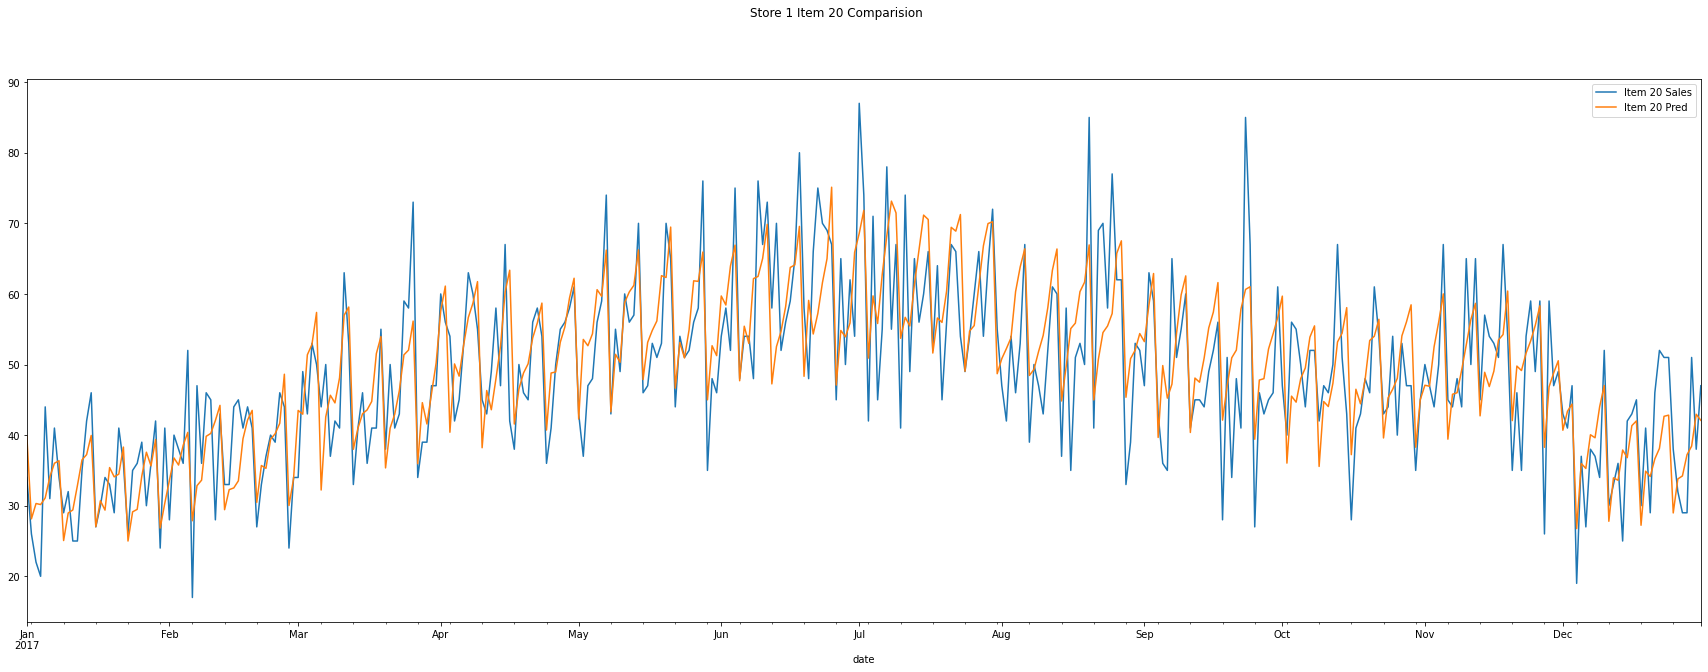

In [155]:
store = int(input("Enter the store number"))
item = int(input("Enter the item number"))
fig= plt.subplots(figsize=(30,10))
sub = error1[error1.store == store].set_index("date")
sub[sub.item == item].actual.plot(legend=True, label = "Item "+str(item)+" Sales")
sub[sub.item == item].pred.plot( legend=True, label="Item " + str(item) + " Pred")
plt.suptitle("Store "+str(store)+" Item "+str(item)+" Comparision");
plt.show()

# Compare - CatBoost

Enter the store number1
Enter the item number20


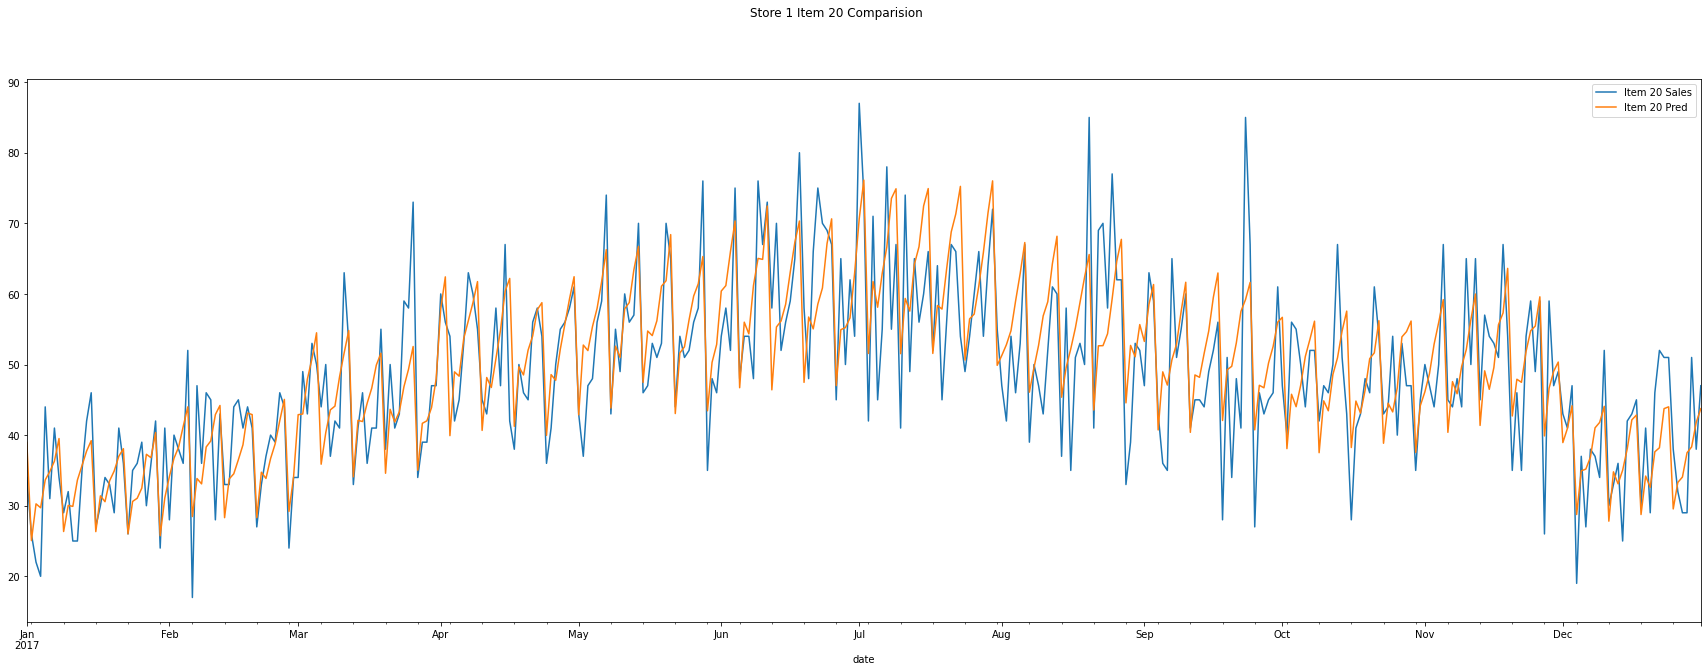

In [152]:
store = int(input("Enter the store number"))
item = int(input("Enter the item number"))
fig= plt.subplots(figsize=(30,10))
sub = error2[error2.store == store].set_index("date")
sub[sub.item == item].actual.plot(legend=True, label = "Item "+str(item)+" Sales")
sub[sub.item == item].pred.plot( legend=True, label="Item " + str(item) + " Pred")
plt.suptitle("Store "+str(store)+" Item "+str(item)+" Comparision");
plt.show()

# Compare XGBoost

Enter the store number1
Enter the item number20


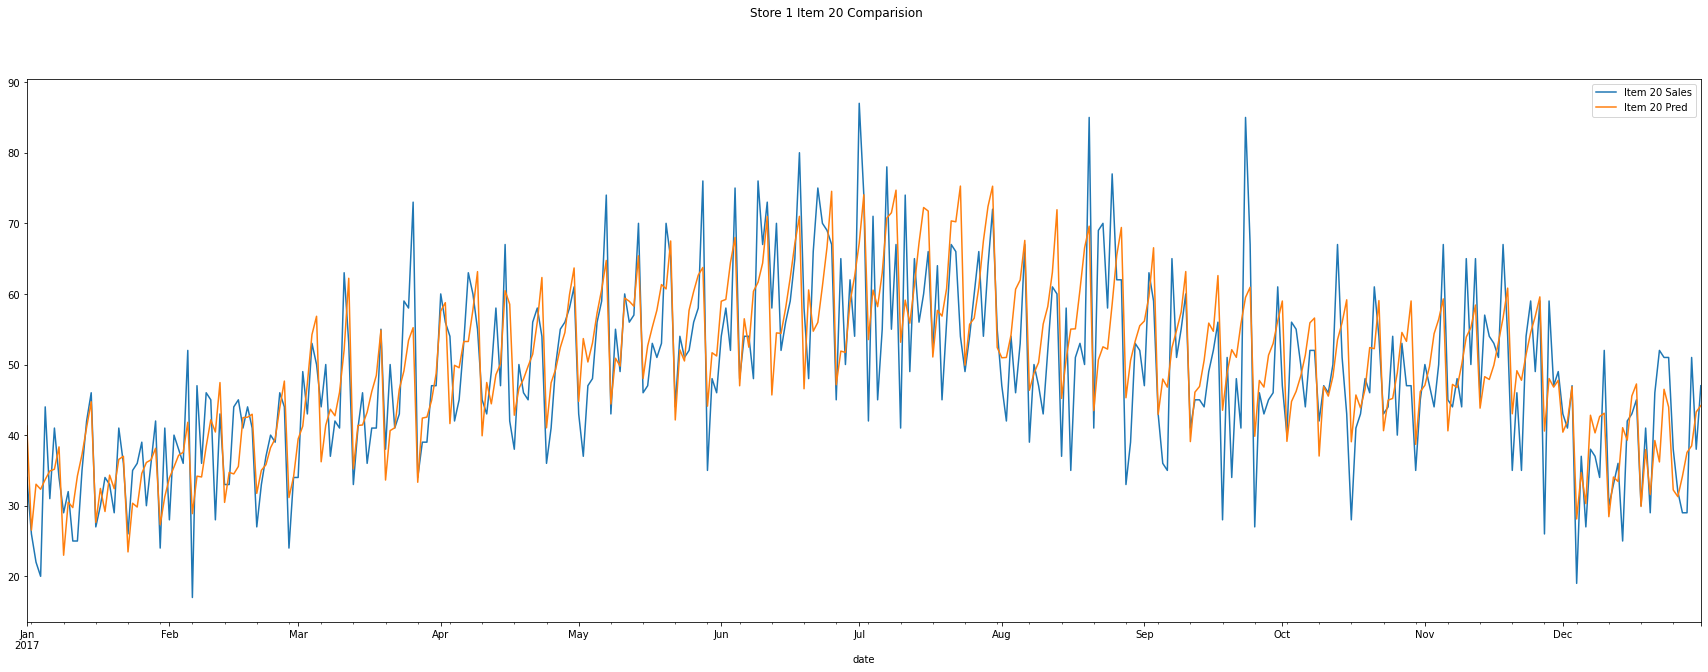

In [154]:
store = int(input("Enter the store number"))
item = int(input("Enter the item number"))
fig= plt.subplots(figsize=(30,10))
sub = error3[error3.store == store].set_index("date")
sub[sub.item == item].actual.plot(legend=True, label = "Item "+str(item)+" Sales")
sub[sub.item == item].pred.plot( legend=True, label="Item " + str(item) + " Pred")
plt.suptitle("Store "+str(store)+" Item "+str(item)+" Comparision");
plt.show()

# Compare - Linear Regression

Enter the store number1
Enter the item number20


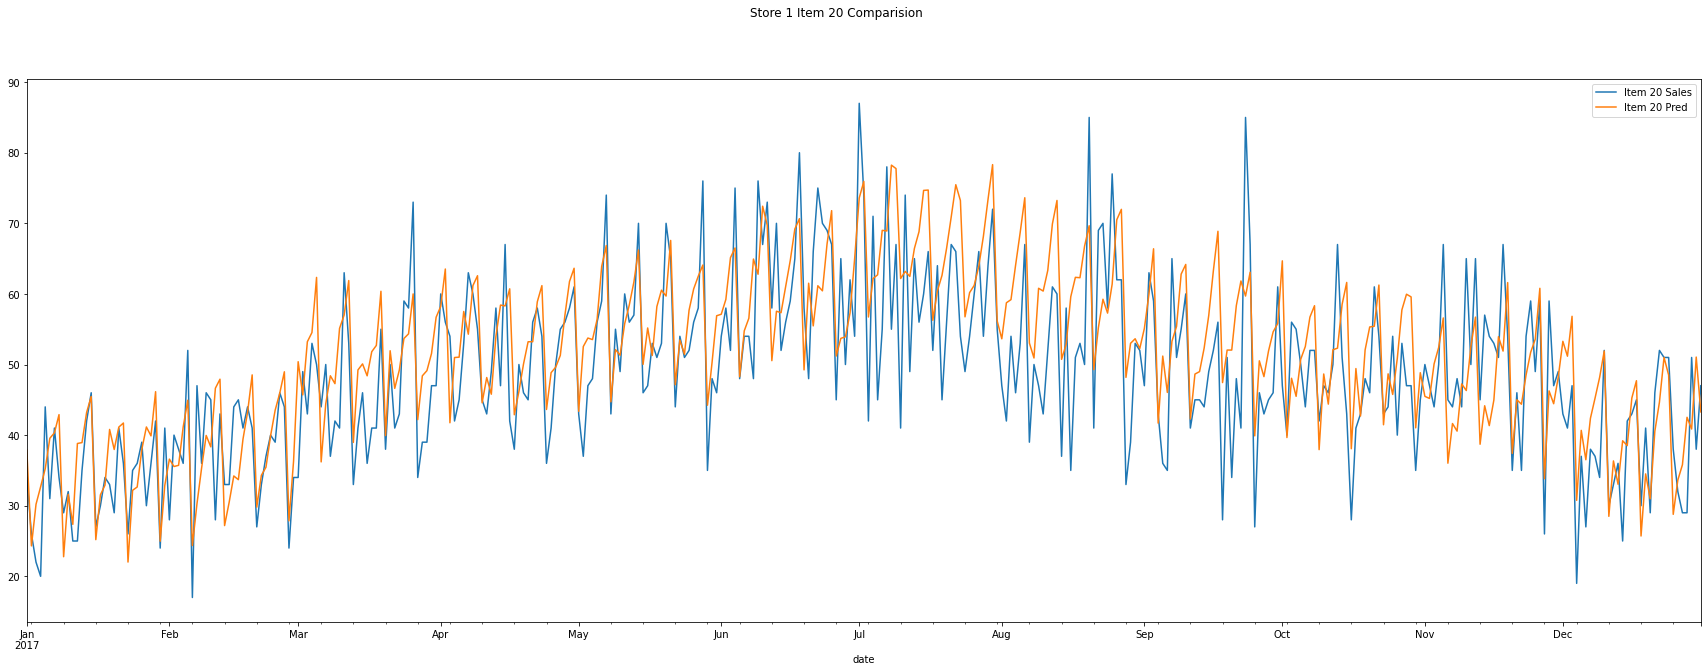

In [153]:
store = int(input("Enter the store number"))
item = int(input("Enter the item number"))
fig= plt.subplots(figsize=(30,10))
sub = error4[error4.store == store].set_index("date")
sub[sub.item == item].actual.plot(legend=True, label = "Item "+str(item)+" Sales")
sub[sub.item == item].pred.plot( legend=True, label="Item " + str(item) + " Pred")
plt.suptitle("Store "+str(store)+" Item "+str(item)+" Comparision");
plt.show()

# Forecast

In [48]:
#  train and validation set.
train = df.loc[(df["date"] < "2018-01-01"), :] # Until beginning of 2017
#val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2018-01-01"), :] # Year of 2017

#dropping useless column
cols = [col for col in train.columns if col not in ['date', 'id', "sales"]]

Y_train = train['sales']
X_train = train[cols]



Y_train.shape, X_train.shape

((913000,), (913000, 5))

In [49]:
test = df.loc[(df["date"] >= "2018-01-01")]

In [55]:
X_train

store  item  month  day_of_year  year
0           1     1      1            1  2013
1           1     1      1            2  2013
2           1     1      1            3  2013
3           1     1      1            4  2013
4           1     1      1            5  2013
...       ...   ...    ...          ...   ...
912995     10    50     12          361  2017
912996     10    50     12          362  2017
912997     10    50     12          363  2017
912998     10    50     12          364  2017
912999     10    50     12          365  2017

[913000 rows x 5 columns]

In [56]:
X_test = test[cols]

In [57]:
X_test

store  item  month  day_of_year  year
0          1     1      1            1  2018
1          1     1      1            2  2018
2          1     1      1            3  2018
3          1     1      1            4  2018
4          1     1      1            5  2018
...      ...   ...    ...          ...   ...
44995     10    50      3           86  2018
44996     10    50      3           87  2018
44997     10    50      3           88  2018
44998     10    50      3           89  2018
44999     10    50      3           90  2018

[45000 rows x 5 columns]

In [24]:
Y_val

1461      19.0
1462      15.0
1463      10.0
1464      16.0
1465      14.0
          ... 
912995    63.0
912996    59.0
912997    74.0
912998    62.0
912999    82.0
Name: sales, Length: 182500, dtype: float64

In [58]:
#since catboost yeild the best result evaluation, forecasting using CATBoost 
from catboost import CatBoostRegressor
CatBoost = CatBoostRegressor()
CatBoost.fit(X_train, Y_train)

Learning rate set to 0.120208
0:	learn: 27.7725647	total: 110ms	remaining: 1m 49s
1:	learn: 26.9418311	total: 238ms	remaining: 1m 58s
2:	learn: 26.3219448	total: 359ms	remaining: 1m 59s
3:	learn: 25.7867663	total: 468ms	remaining: 1m 56s
4:	learn: 25.2686498	total: 594ms	remaining: 1m 58s
5:	learn: 24.8598149	total: 700ms	remaining: 1m 55s
6:	learn: 24.4193891	total: 828ms	remaining: 1m 57s
7:	learn: 24.0469750	total: 1.01s	remaining: 2m 5s
8:	learn: 23.6777166	total: 1.13s	remaining: 2m 4s
9:	learn: 23.3199186	total: 1.22s	remaining: 2m 1s
10:	learn: 23.0198665	total: 1.35s	remaining: 2m 1s
11:	learn: 22.7203324	total: 1.45s	remaining: 1m 59s
12:	learn: 22.4740846	total: 1.57s	remaining: 1m 59s
13:	learn: 22.1602145	total: 1.72s	remaining: 2m
14:	learn: 21.9274242	total: 1.84s	remaining: 2m 1s
15:	learn: 21.6801804	total: 1.95s	remaining: 2m
16:	learn: 21.4771945	total: 2.08s	remaining: 1m 59s
17:	learn: 21.2275432	total: 2.18s	remaining: 1m 59s
18:	learn: 21.0338922	total: 2.29s	rema

In [59]:
forecastCAT = pd.DataFrame({
    "date":test.date,
    "date_of_year":test.day_of_year,
    "month":test.month,
    "year":test.year,
    "store":test.store,
    "item":test.item,
    "sales":CatBoost.predict(X_test)
})

In [61]:
forecastCAT.head(50)

date  date_of_year  month  year  store  item      sales
0  2018-01-01             1      1  2018      1     1  13.531633
1  2018-01-02             2      1  2018      1     1  13.531633
2  2018-01-03             3      1  2018      1     1  11.257615
3  2018-01-04             4      1  2018      1     1  11.257615
4  2018-01-05             5      1  2018      1     1  13.847543
5  2018-01-06             6      1  2018      1     1  16.659285
6  2018-01-07             7      1  2018      1     1  16.659285
7  2018-01-08             8      1  2018      1     1  19.458124
8  2018-01-09             9      1  2018      1     1   9.808224
9  2018-01-10            10      1  2018      1     1   9.808224
10 2018-01-11            11      1  2018      1     1  11.058403
11 2018-01-12            12      1  2018      1     1  14.549478
12 2018-01-13            13      1  2018      1     1  14.549478
13 2018-01-14            14      1  2018      1     1  16.408512
14 2018-01-15            15      1  2018      1     1  13.827070
15 2018-01-16            16      1  2018      1     1  13.827070
16 2018-01-17            17      1  2018      1     1  12.021045
17 2018-01-18            18      1  2018      1     1  12.681744
18 2018-01-19            19      1  2018      1     1  12.681744
19 2018-01-20            20      1  2018      1     1  15.610828
20 2018-01-21            21      1  2018      1     1  16.677903
21 2018-01-22            22      1  2018      1     1  13.742802
22 2018-01-23            23      1  2018      1     1  13.742802
23 2018-01-24            24      1  2018      1     1  12.052876
24 2018-01-25            25      1  2018      1     1  12.866208
25 2018-01-26            26      1  2018      1     1  12.866208
26 2018-01-27            27      1  2018      1     1  16.432827
27 2018-01-28            28      1  2018      1     1  16.432827
28 2018-01-29            29      1  2018      1     1  17.794786
29 2018-01-30            30      1  2018      1     1  11.141161
30 2018-01-31            31      1  2018      1     1  11.141161
31 2018-02-01            32      2  2018      1     1  13.816192
32 2018-02-02            33      2  2018      1     1  16.206240
33 2018-02-03            34      2  2018      1     1  16.206240
34 2018-02-04            35      2  2018      1     1  19.415619
35 2018-02-05            36      2  2018      1     1  19.415619
36 2018-02-06            37      2  2018      1     1  12.753980
37 2018-02-07            38      2  2018      1     1  15.045557
38 2018-02-08            39      2  2018      1     1  16.512396
39 2018-02-09            40      2  2018      1     1  16.517691
40 2018-02-10            41      2  2018      1     1  16.517691
41 2018-02-11            42      2  2018      1     1  17.552474
42 2018-02-12            43      2  2018      1     1  16.675260
43 2018-02-13            44      2  2018      1     1  16.675260
44 2018-02-14            45      2  2018      1     1  15.582520
45 2018-02-15            46      2  2018      1     1  15.668064
46 2018-02-16            47      2  2018      1     1  15.668064
47 2018-02-17            48      2  2018      1     1  18.389092
48 2018-02-18            49      2  2018      1     1  18.802967
49 2018-02-19            50      2  2018      1     1  20.161529

Enter no. of store1
Enter no. of item20


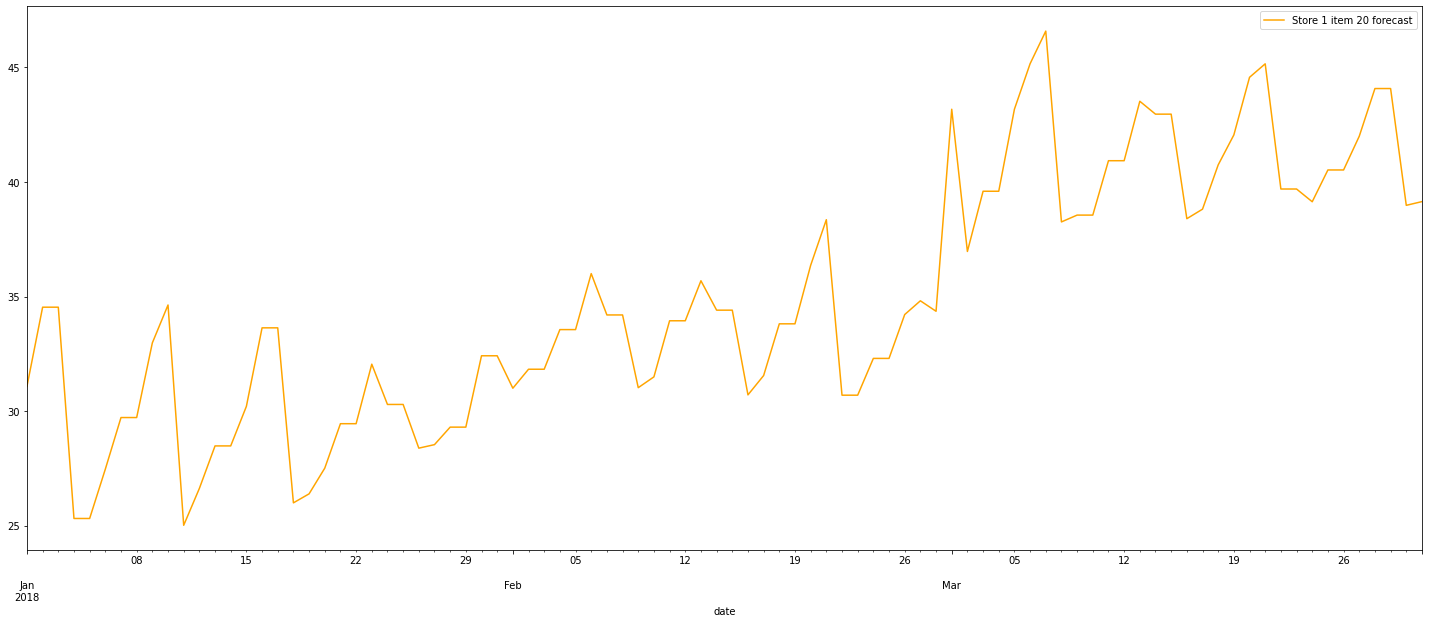

In [35]:
store=int(input("Enter no. of store"))
item=int(input("Enter no. of item"))
forecastCAT[(forecastCAT.store==store) & (forecastCAT.item==item)].set_index("date").sales.plot(color = "orange", figsize = (25,10),legend=True,label="Store "+str(store)+" item "+str(item)+" forecast");

In [37]:
train = df.loc[(df["date"] >= "2013-01-01") & (df["date"] < "2018-01-01")]

In [38]:
train

date  store  item  sales  id  month  day_of_year  year
0      2013-01-01      1     1   13.0 NaN      1            1  2013
1      2013-01-02      1     1   11.0 NaN      1            2  2013
2      2013-01-03      1     1   14.0 NaN      1            3  2013
3      2013-01-04      1     1   13.0 NaN      1            4  2013
4      2013-01-05      1     1   10.0 NaN      1            5  2013
...           ...    ...   ...    ...  ..    ...          ...   ...
912995 2017-12-27     10    50   63.0 NaN     12          361  2017
912996 2017-12-28     10    50   59.0 NaN     12          362  2017
912997 2017-12-29     10    50   74.0 NaN     12          363  2017
912998 2017-12-30     10    50   62.0 NaN     12          364  2017
912999 2017-12-31     10    50   82.0 NaN     12          365  2017

[913000 rows x 8 columns]

Enter no. of store1
Enter no. of item20


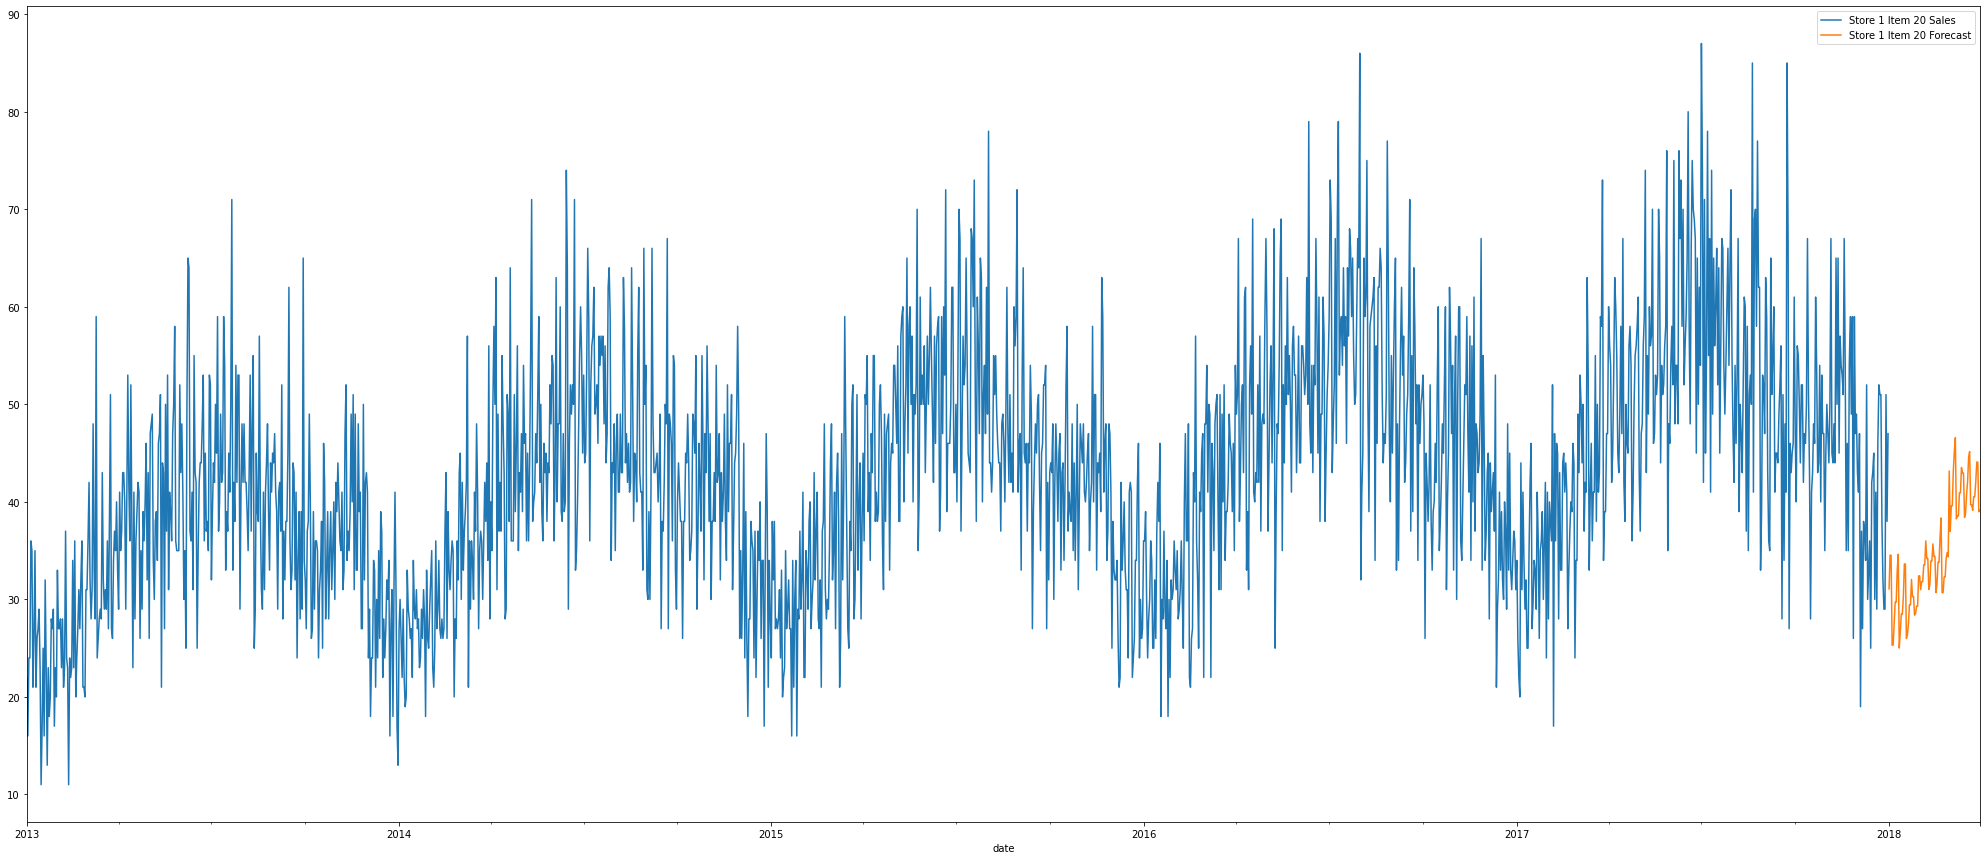

In [39]:
store=int(input("Enter no. of store"))
item=int(input("Enter no. of item"))
train[(train.store == store) & (train.item == item)].set_index("date").sales.plot(figsize = (35,15),legend=True, label = "Store "+str(store)+" Item "+str(item)+" Sales")
forecastCAT[(forecastCAT.store == store) & (forecastCAT.item == item)].set_index("date").sales.plot(legend=True, label = "Store " + str(store)+ " Item "+str(item) + " Forecast");

# Hyper-parameter tuning for Linear Regression

In [28]:
#randomized cv
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV

In [29]:
LinearRegression().get_params()

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': 'deprecated',
 'positive': False}

In [31]:
lr = RandomizedSearchCV(LinearRegression(),{
    'normalize':[True,False]
},
                       cv = 5,
                       return_train_score = False,
                       n_iter = 2)
lr.fit(X_train,Y_train)
print("The best hyperparameters :")
print(lr.best_params_)
print("")
print("The best score:")
print(lr.best_score_)

The best hyperparameters :
{'normalize': False}

The best score:
0.7757081226567377


In [32]:
from sklearn.linear_model import LinearRegression
first_model = LinearRegression(normalize = False)
first_model.fit(X_train, Y_train)
print("TRAIN SMAPE:", smape(Y_train, first_model.predict(X_train)))
print("VALID SMAPE:", smape(Y_val, first_model.predict(X_val)))
pred = first_model.predict(X_train)
print("MAE:",mean_absolute_error(Y_train, pred))
print("RMSE:",mean_squared_error(Y_train, pred))
print("R2 Score:",r2_score(Y_train, pred))
print("MAPE:",mean_absolute_percentage_error(Y_train, pred))

TRAIN SMAPE: 4.325929433210078
VALID SMAPE: 4.112022289095299
MAE: 0.15344420375028564
RMSE: 0.03996026401797561
R2 Score: 0.880171873470002
MAPE: 15796854102.166037
